In [ ]:
!pip install luminaire

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime

import itertools

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '{:.15f}'.format(x))

In [ ]:
df_shipment = pd.read_csv('result_shipment_only.csv')
#df2 = pd.read_csv('result_shipment_only_2.csv')
#df3 = pd.read_csv('result_shipment_only_3.csv')
#df = pd.concat([df1, df2, df3])
#df_shipment = df_shipment.assign(generic_cust_item_id=(df_shipment['UCH_LEVEL_G'].astype(str) + '_' + df_shipment['BASECODE'].astype(str)).astype('category').cat.codes)
df_shipment.columns = [c.lower() for c in df_shipment.columns]
#Converting fscl_wk_end_dt column to datetime format
df_shipment['fscl_wk_end_dt'] = pd.to_datetime(df_shipment['fscl_wk_end_dt'])
#df_shipment.set_index('fscl_wk_end_dt', inplace=True)

df_cust_po = pd.read_csv('result_cust_po.csv')
#df2 = pd.read_csv('result_shipment_only_2.csv')
#df3 = pd.read_csv('result_shipment_only_3.csv')
#df = pd.concat([df1, df2, df3])
#df_cust_po = df_cust_po.assign(generic_cust_item_id=(df_cust_po['UCH_LEVEL_G'].astype(str) + '_' + df_cust_po['BASECODE'].astype(str)).astype('category').cat.codes)
df_cust_po.columns = [c.lower() for c in df_cust_po.columns]
#Converting fscl_wk_end_dt column to datetime format
df_cust_po['fscl_wk_end_dt'] = pd.to_datetime(df_cust_po['fscl_wk_end_dt'])
#df_cust_po.set_index('fscl_wk_end_dt', inplace=True)

df_po_vs_shipment = pd.merge(df_shipment[['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material','dlv_units']], df_cust_po[['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material','total_units_ordered']], on=['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material'], how="inner")
df_po_vs_shipment = df_po_vs_shipment.assign(generic_cust_item_id=(df_po_vs_shipment['uch_level_g'].astype(str) + '_' + df_po_vs_shipment['basecode'].astype(str)).astype('category').cat.codes)

df_po_vs_shipment.set_index(['fscl_wk_end_dt'], inplace=True)
df_po_vs_shipment.total_units_ordered = df_po_vs_shipment.total_units_ordered.astype(int)
df_po_vs_shipment = df_po_vs_shipment[['uch_level_g','basecode','generic_cust_item_id', 'dlv_units']]
df_po_vs_shipment.to_csv('df_po_vs_shipment.csv')

df_po_vs_shipment_agg=df_po_vs_shipment.reset_index().groupby(['uch_level_g','basecode','generic_cust_item_id', 'fscl_wk_end_dt'])[["dlv_units"]].agg(["sum"]).reset_index()
df_po_vs_shipment_agg.columns = ['uch_level_g','basecode','generic_cust_item_id', 'fscl_wk_end_dt','dlv_units']
#df_po_vs_shipment_agg.set_index('fscl_wk_end_dt', inplace=True)
df_po_vs_shipment_agg

,uch_level_g,basecode,generic_cust_item_id,fscl_wk_end_dt,dlv_units
0,CA4000320,681000145500,0,2017-11-25,38
1,CA4000320,681000145500,0,2017-12-23,34
2,CA4000320,681000145500,0,2018-02-03,40
3,CA4000320,681000145500,0,2018-03-17,35
4,CA4000320,681000145500,0,2018-04-28,43
...,...,...,...,...,...
15419,CA4001315,681008965100,540,2021-03-13,120
15420,CA4001315,681008965100,540,2021-05-08,15
15421,CA4001315,681008965100,540,2021-05-22,60
15422,CA4001315,681008965100,540,2021-05-29,15


In [ ]:
df_po_vs_shipment_agg.columns = ['uch_level_g','basecode','generic_cust_item_id','dteday','raw']
df_po_vs_shipment_agg[df_po_vs_shipment_agg.generic_cust_item_id == 303]
test_df = df_po_vs_shipment_agg[df_po_vs_shipment_agg.generic_cust_item_id == 303]
test_df['dteday'] = pd.to_datetime(test_df['dteday'], format='%Y-%m-%d')
test_df.index = test_df['dteday']
test_df = test_df.drop('dteday',axis=1)
test_df = test_df.asfreq('W-Sat')
test_df = test_df[['raw']]
test_df = test_df.fillna(test_df.mean())
test_df['raw'] =  test_df['raw'].astype(float)
test_df

,raw
dteday,
2017-12-02,12.000000000000000
2017-12-09,4.076923076923077
2017-12-16,4.076923076923077
2017-12-23,4.076923076923077
2017-12-30,4.076923076923077
...,...
2021-06-05,3.000000000000000
2021-06-12,4.076923076923077
2021-06-19,2.000000000000000


In [ ]:
df_po_vs_shipment_agg[df_po_vs_shipment_agg.uch_level_g == 'CA4000410']

,uch_level_g,basecode,generic_cust_item_id,dteday,raw
9332,CA4000410,681000112500,303,2017-12-02,12
9333,CA4000410,681000112500,303,2018-01-06,8
9334,CA4000410,681000112500,303,2018-02-24,3
9335,CA4000410,681000112500,303,2018-03-24,8
9336,CA4000410,681000112500,303,2018-04-28,3
...,...,...,...,...,...
10107,CA4000410,681008959700,310,2021-06-05,27
10108,CA4000410,681008959700,310,2021-06-12,9
10109,CA4000410,681008959700,310,2021-06-19,19
10110,CA4000410,681008959700,310,2021-06-26,12


In [ ]:
import luminaire
from luminaire.model.window_density import WindowDensityHyperParams, WindowDensityModel
from luminaire.exploration.data_exploration import DataExploration

In [ ]:
# Without log transformation: is_log_transformed = False (Default)
de = DataExploration(fill_rate=0.01#,is_log_transformed = True
                     )
test_df_2, profile = de.profile(df=test_df)  
trend_change_list = list(profile['trend_change_list'])
test_df_2.head()

,raw,interpolated
2020-10-23,nan,3.957620263962401
2020-10-24,4.076923076923077,4.076923076923077
2020-10-25,nan,4.012251874562301
2020-10-26,nan,4.020773098776319
2020-10-27,nan,4.029294322990336


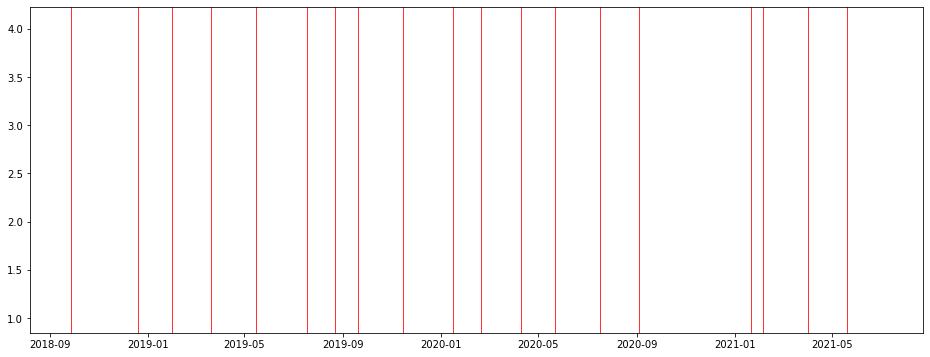

In [ ]:
trend_change_list = list(profile['trend_change_list'])
change_point_list = list(profile['change_point_list'])
trendline = test_df[test_df.index.isin(trend_change_list)]

def change_point_plot(df, trend_change_list):
    plt.figure(figsize=(16,6))
    plt.plot(df['raw'], linestyle = '-')
    
    #plt.title('',fontsize=14)
    for x in trend_change_list:
        plt.axvline(x,lw=0.8, color='red')
    plt.plot(trendline,lw=2, linestyle='dashed', color = 'green')    
change_point_plot(test_df_2, trend_change_list)

In [ ]:
from luminaire.optimization.hyperparameter_optimization import HyperparameterOptimization
op = HyperparameterOptimization(freq='D')
optimz = op.run(data=test_df_2)
print(optimz)

 90%|█████████ | 45/50 [02:22<00:18,  3.72s/it, best loss: 0.2153056953204977]

In [ ]:
from luminaire.exploration.data_exploration import DataExploration
de_optimz = DataExploration(**optimz)
test_df_2, bike_pre_prc = de_optimz.profile(test_df)
print(test_df_2)

None


In [ ]:
bike_pre_prc

{'ErrorMessage': 'Too few observed data near the prediction date',
 'success': False}

In [ ]:
test_df

,raw
dteday,
2017-12-02,12.000000000000000
2017-12-09,0.000000000000000
2017-12-16,0.000000000000000
2017-12-23,0.000000000000000
2017-12-30,0.000000000000000
...,...
2021-06-05,3.000000000000000
2021-06-12,0.000000000000000
2021-06-19,2.000000000000000
